# Comparing a naive neural net using word embeddings to a linear model for prediction of cholesterol content of foods

In [1]:
import sys
import os
from operator import itemgetter
import _pickle as pkl
import random
import pandas
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.model_selection import *
# from sklearn.linear_model import *
import sklearn
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib import learn
import gensim
import tflearn

/home/andylane/Envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

## Load data
These were previously collected from a collection of recipes with cholesterol information.

In [2]:
# Load pre-trained Google News word vector embeddings
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
 
# Load the traning/test data
words = pkl.load(open("tf_data/training_data_names.pkl", "rb")) # this is a stemmed/tokenized version
X = pkl.load(open("tf_data/training_data_names_unstemmed.pkl", "rb")) # Recipe names
y = pkl.load(open("tf_data/training_labels_num.pkl", "rb")) # Corresponding cholesterol content for each recipe

# Slice out 20% for test data. This isn't random. OK for development, but need to go back and check later.
X_test = X[3152:]
y_test = y[3152:]

# The rest is the training data
X = X[:3152]
y = y[:3152]

# We also have some alternative test data from chain restaurant menus, but there are issues
# with testing the model on this. Explain in blog.
ground_truth_X = pkl.load(open("tf_data/test_data_names.pkl", "rb"))
ground_truth_y = pkl.load(open("tf_data/test_labels_num.pkl", "rb"))

In [3]:
# This time we're carrying out the prediction as a regression
# rather than a classification. To start with, an r2 of 
# predicted vs true test cholesterol is used as a metric; the MSE
# is also used.
import scipy
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [4]:
# Notes to self:
## There are 300,000 words in the Google News model
len(model.vocab)

## Get words from given index
model.wv.index2word[2898]
# Out: 'judges"

## Find the odd word out:
model.doesnt_match(X[3].split())

## Access recipes:
print(X[3])
print(words[3])

## Get the similarity between two phrases. This is implemented in gensim as
## just the cosine similarity of the means of the two vectors
model.n_similarity(X[3].split(), X[7].split())
model.similarity("saucepan", "food")

## There's a case for n-gramming with underscores:
model.most_similar(["cinnamon", "roll"])
# Out e.g.: coconut_flakes, graham_cracker_crumbs
model.most_similar("cinnamon_roll")
# Out e.g.: cinnamon_rolls, oatmeal_cookie, peach_pie

Campfire Banana Splits
campfir banana split


[('cinnamon_rolls', 0.655969500541687),
 ('oatmeal_cookie', 0.6287018656730652),
 ('peach_pie', 0.6216853857040405),
 ('banana_walnut', 0.6158987879753113),
 ('baked_beans_peaches', 0.6140761375427246),
 ('waffle_cone', 0.6071436405181885),
 ('fruit_cobbler', 0.6069991588592529),
 ('snickerdoodle', 0.6056694984436035),
 ('turtle_cheesecake', 0.6054642200469971),
 ('yogurt_parfait', 0.6052801609039307)]

In [5]:
# Remove words that are not in the Google News model
# TODO: Also remove stopwords - not necessary to average e.g. "in"
def prune_words_not_found_in_model(X, y):
    filtered_x = []
    filtered_y = []
    for index, recipe in enumerate(X):
        recipe_words = recipe.split()
        recipe_words = list(filter(lambda x: x in model.vocab, recipe_words))
        if len(recipe_words) > 0: #don't add empty lists - the LinReg can't fit NaNs
            filtered_x.append(recipe_words)
            filtered_y.append(y[index]) # to keep y_ same index
        else:
            None
    return filtered_x, filtered_y

In [6]:
def input_preprocessor(dish, model=model, foodfilter=True):
    '''
    filter for words that are in the model and extract bigrams
    also optionally only keep words above a cosine similarity
    threshold with the word "food".
    Usage: input_preprocessor(dish). Returns np.array of size model dimensions 
        (300 dimensions for GoogleNews Word2Vec model)
    dish: list of words in recipe title
    model: a word2vec model
    ''' 
    # Construct n-grams of pairs of words
    ngrammed = []
    ngrammed.extend(dish)
    for index, word in enumerate(dish):
        if index+1 < len(dish):
            ngrammed.append(word + "_" + dish[index+1])
    # Duplicate words in a dish won't help the model
    ngrammed = set(ngrammed)
    # only include words that have a cosine similarity with the word "food" above a certain threshold
    # better idea: weight them against cosine similarity to food!
    if foodfilter == True:
        foodywords = list(filter(lambda x: x in model.vocab and model.similarity(x, "food") > 0.16, ngrammed))
        # if no words are that close to food, pick the top two words
        if len(foodywords) == 0:
            sims = []
            for x in ngrammed:
                if x in model.vocab:
                    sims.append((x, model.similarity(x, "food")))
            foodywords = [word for word, similarity in sorted(sims, key=itemgetter(1))[:2]]
        foodywords = set(foodywords)
    elif foodfilter == False: # don't filter based on similarity to a food
        foodywords = list(filter(lambda x: x in model.vocab, ngrammed))
    # Return the average of all the foody-word vectors in the recipe name
    return np.array([model[w] for w in foodywords]).mean(axis=0)

In [7]:
# Apply the input preprocessor across the filtered list of recipes
def prune_and_preprocess(X, y, foodfilter=True):
    filtered_x, filtered_y  = prune_words_not_found_in_model(X, y)
    filtered_x_vect = []
    for index, i in enumerate(filtered_x):
        filtered_x_vect.append(input_preprocessor(i, model, foodfilter=foodfilter))
    filtered_x_vect = np.array(filtered_x_vect)
    filtered_y = np.array([filtered_y]).transpose()
    filtered_y = np.array(filtered_y)
    return filtered_x_vect, np.transpose(filtered_y)

In [8]:
filtered_x_vect, filtered_y = prune_and_preprocess(X, y, foodfilter=False)

In [9]:
X_test_vect, y_test_vect = prune_and_preprocess(X_test, y_test, foodfilter=False)

Posit that cholesterol is a combination of input word vector, some weight, some bias and some error term. 

In [10]:
from random import randint

In [104]:
# Build input layer
def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.2)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.001, shape=shape)
    return tf.Variable(initial)

# Build a linear layer
def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

In [105]:
from tensorflow.contrib.data import Dataset, Iterator

In [107]:
tf.reset_default_graph()
minibatch_size = 32
steps_per_epoch = int(filtered_y.shape[1] / minibatch_size)
epochs = 1000
g=tf.Graph()

with g.as_default():
    training_data = Dataset.from_tensor_slices((filtered_x_vect, filtered_y.transpose()))
    training_data=training_data.batch(minibatch_size).repeat()
    iterator = training_data.make_one_shot_iterator()
    
    steps = epochs*steps_per_epoch
    beta = 0.0001
    batched_x, batched_y = iterator.get_next() 
    tanh = tf.nn.tanh(full_layer(batched_x, 10))
    relu = tf.nn.relu(full_layer(tanh, 10))
    linear = full_layer(relu, 1)

    regularizer = tf.nn.l2_loss(linear)
    mse = tf.losses.mean_squared_error(labels=batched_y, predictions=linear)
    mse = tf.reduce_mean(mse + beta * regularizer)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(mse)
    accuracy = tf.losses.mean_squared_error(labels=batched_y, predictions=linear)
    
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(steps):
        if i % 10000 == 0:
            train_accuracy = sess.run(accuracy)
            print("step {}, training accuracy {}".format(i, train_accuracy))
            test_accuracy = np.mean(
        [sess.run(accuracy, feed_dict={batched_x: X_test_vect, batched_y: y_test_vect.transpose()})])
            print("test accuracy: {}".format(test_accuracy))
        sess.run(train_step)
    test_accuracy = np.mean(
        [sess.run(accuracy, feed_dict={batched_x: X_test_vect, batched_y: y_test_vect.transpose()})])
    predictions = sess.run(linear, feed_dict={batched_x: X_test_vect, batched_y: y_test_vect.transpose()})
print("test accuracy: {}".format(test_accuracy))


step 0, training accuracy 4355.64208984375
test accuracy: 12689.6689453125
step 10000, training accuracy 3159.58837890625
test accuracy: 5288.44775390625
step 20000, training accuracy 2355.231689453125
test accuracy: 4208.5673828125
step 30000, training accuracy 6188.68310546875
test accuracy: 3989.829345703125
step 40000, training accuracy 7579.80712890625
test accuracy: 3877.889892578125
step 50000, training accuracy 1579.36328125
test accuracy: 3809.8583984375
step 60000, training accuracy 2147.83154296875
test accuracy: 3756.02880859375
step 70000, training accuracy 2656.0888671875
test accuracy: 3698.65869140625
step 80000, training accuracy 1852.2677001953125
test accuracy: 3647.11328125
step 90000, training accuracy 2812.6005859375
test accuracy: 3608.58349609375
test accuracy: 3586.373779296875


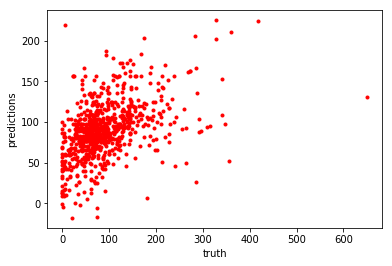

In [110]:
predictionsi, truthi = [int(i) for i in predictions.transpose()[0]], [i for i in y_test_vect[0]]
plt.plot(truthi, predictionsi, 'r.')
plt.ylabel('predictions')
plt.xlabel('truth')
plt.show()

In [109]:
rsquared(truthi, predictionsi)

0.20263495814173069

In [15]:
def plot_test_epochs(model, result_, subset=None):
    i = 1
    if subset != None:
        result_["history"] = np.take(result_["history"], range(0, len(result_["epoch"]), subset), axis=1)
        result_["epoch"] = result_["epoch"][::subset]
    while i < result_["history"].shape[1]:
        plt.plot(result_["history"][:,0], result_["history"][:,i], 'r.')
        plt.ylabel('y_')
        plt.xlabel('y')
        plt.show()
        print("Epoch " + str(result_["epoch"][i]) + ": R2 = " + str(rsquared(result_["history"][:,0], result_["history"][:,i])))
        print("Epoch " + str(result_["epoch"][i]) + ": MSE = " + str(mean_squared_error(result_["history"][:,0], result_["history"][:,i])))
        i+= 1
#     return result["epoch"]

In [16]:
def rsquared_one_to_many(result_):
    out = []
    truth = result_["history"][:,0]
    for column in range(1, result_["history"][:,1:].shape[1]+1):
        epoch_result = result_["history"][:,column]
        out.append(rsquared(epoch_result, truth))
    print(max(out))
    return out

def mse_one_to_many(result_):
    out = []
    truth = result_["history"][:,0]
    for column in range(1, result_["history"][:,1:].shape[1]+1):
        epoch_result = result_["history"][:,column]
        out.append(mean_squared_error(epoch_result, truth))
    print(min(out))
    return out


## Train a network

In [38]:
nodes = 10
tf.reset_default_graph()
tflearn.init_graph()

net = tflearn.input_data(shape=[None, 300])
#net = tflearn.fully_connected(net, nodes, activation='linear') 
#net = tflearn.conv_1d(net, 1, 1, activation='linear') 

net = tflearn.fully_connected(net, nodes, activation="tanh", regularizer="L2")
#net = tflearn.dropout(net, 0.5) #was 0.9
net = tflearn.fully_connected(net, nodes, activation="relu")#, regularizer="L2")
net = tflearn.fully_connected(net, 1, activation='linear') 
#net = tflearn.dropout(net, 0.5) #was 0.9
net = tflearn.regression(net, optimizer="adam",loss="mean_square", metric="R2", learning_rate=0.001) #was 0.001

dnnmodel = tflearn.DNN(net, tensorboard_verbose=3, tensorboard_dir="graph")
#dnnmodel = tflearn.DNN(net)

#dnnmodel.load("dnn_models/dnn_10node_200epoch_tan-relu-linear_80pcttrain_nosoftmax.tflearn")
#dnnmodel.fit(filtered_x_vect, filtered_y, validation_set=0.2, batch_size = 16, n_epoch = 20, show_metric=True)
#print(rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect[3152:])], [i[0] for i in filtered_y[3152:]]))

In [39]:
result, dnnmodel = test_every_n_epoch(dnnmodel, 5, 400, batch_size=100)

Training Step: 12799  | total loss: 1796.16333 | time: 0.134s
| Adam | epoch: 400 | loss: 1796.16333 - R2: 0.8618 -- iter: 3100/3150
Training Step: 12800  | total loss: 1737.36523 | time: 0.138s
| Adam | epoch: 400 | loss: 1737.36523 - R2: 0.8715 -- iter: 3150/3150
--


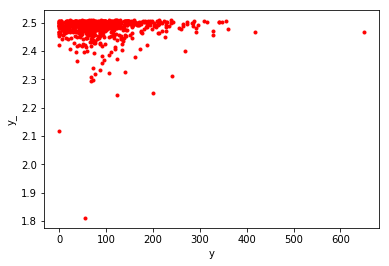

Epoch 5: R2 = 0.000550605503025
Epoch 5: MSE = 12240.920743


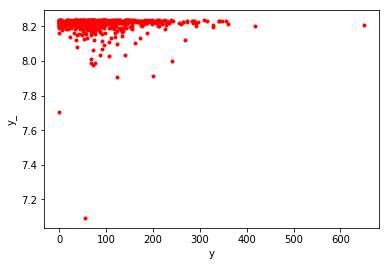

Epoch 10: R2 = 0.00031396575815
Epoch 10: MSE = 11263.2697638


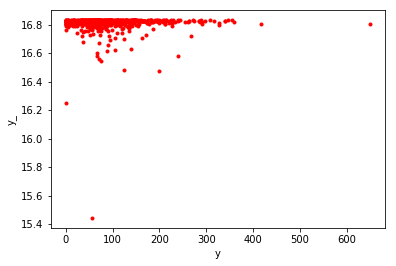

Epoch 15: R2 = 0.000251493329456
Epoch 15: MSE = 9919.65777572


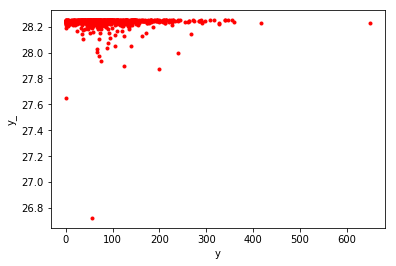

Epoch 20: R2 = 0.00022144540675
Epoch 20: MSE = 8363.64769693


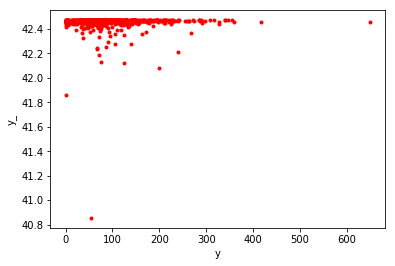

Epoch 25: R2 = 0.000202333124976
Epoch 25: MSE = 6790.53045563


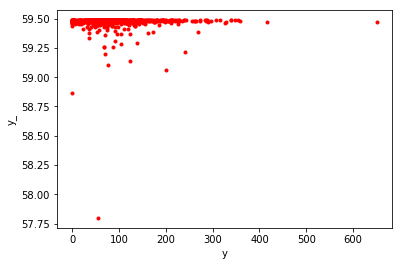

Epoch 30: R2 = 0.000186479607831
Epoch 30: MSE = 5440.06017926


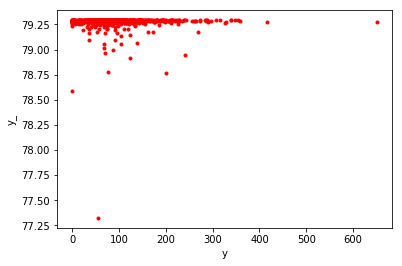

Epoch 35: R2 = 0.000159027444099
Epoch 35: MSE = 4597.56181106


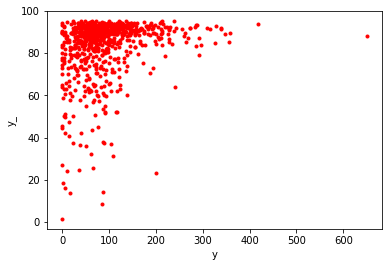

Epoch 40: R2 = 0.0516743329095
Epoch 40: MSE = 4286.61880851


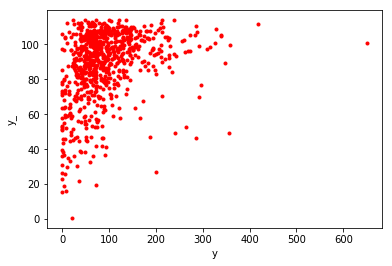

Epoch 45: R2 = 0.092751958992
Epoch 45: MSE = 4060.05985721


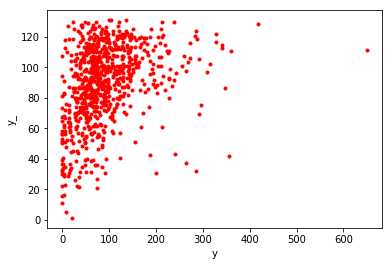

Epoch 50: R2 = 0.106741628681
Epoch 50: MSE = 4003.11473927


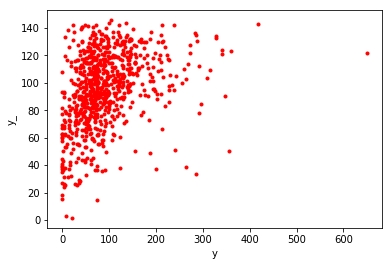

Epoch 55: R2 = 0.117690495615
Epoch 55: MSE = 3977.99281916


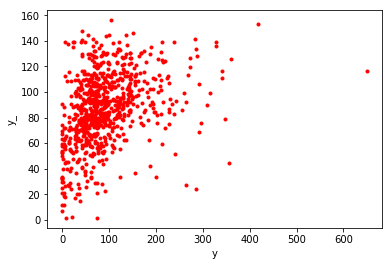

Epoch 60: R2 = 0.124112573322
Epoch 60: MSE = 3946.95232522


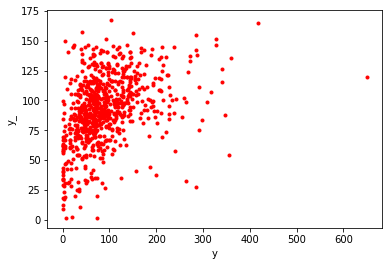

Epoch 65: R2 = 0.135149277795
Epoch 65: MSE = 3880.90881685


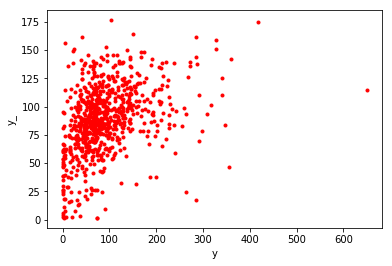

Epoch 70: R2 = 0.140041058669
Epoch 70: MSE = 3872.1968721


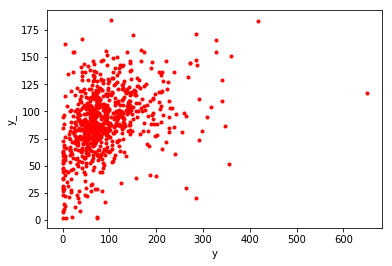

Epoch 75: R2 = 0.14659927918
Epoch 75: MSE = 3831.50405892


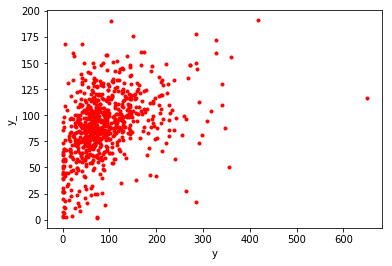

Epoch 80: R2 = 0.150871847023
Epoch 80: MSE = 3814.39257035


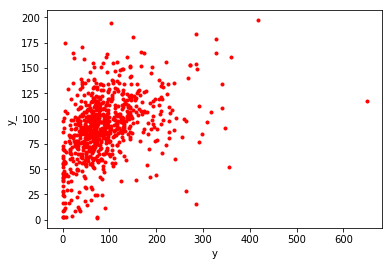

Epoch 85: R2 = 0.156810316794
Epoch 85: MSE = 3792.02859718


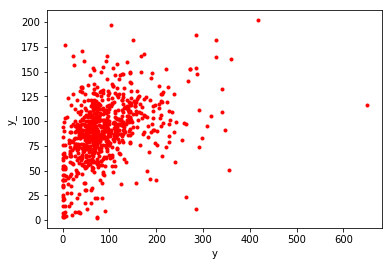

Epoch 90: R2 = 0.160445128676
Epoch 90: MSE = 3774.24054883


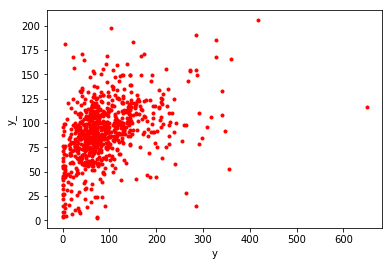

Epoch 95: R2 = 0.165006906331
Epoch 95: MSE = 3746.23709857


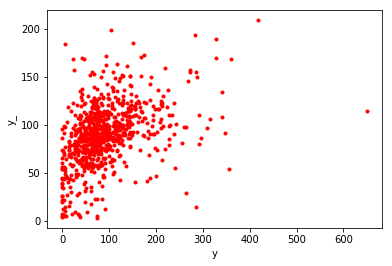

Epoch 100: R2 = 0.168520168176
Epoch 100: MSE = 3733.80790657


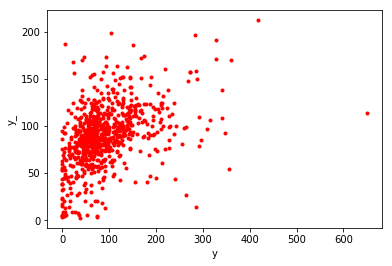

Epoch 105: R2 = 0.172341073927
Epoch 105: MSE = 3717.81099148


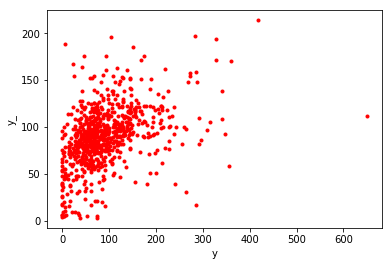

Epoch 110: R2 = 0.17457715314
Epoch 110: MSE = 3701.19202839


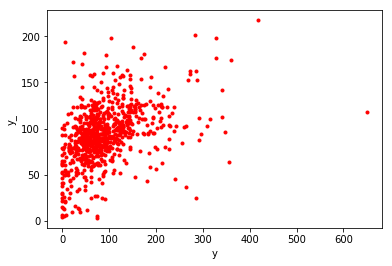

Epoch 115: R2 = 0.177540393082
Epoch 115: MSE = 3695.13901084


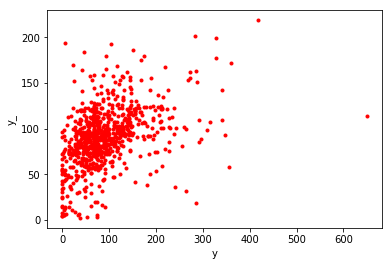

Epoch 120: R2 = 0.181475758571
Epoch 120: MSE = 3673.62330776


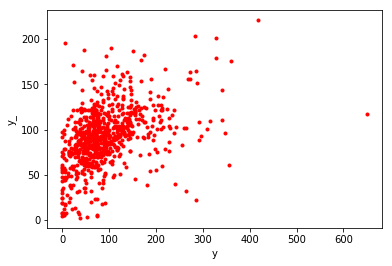

Epoch 125: R2 = 0.184870113878
Epoch 125: MSE = 3656.48434647


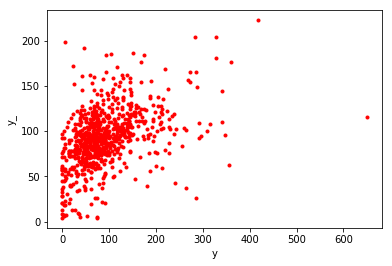

Epoch 130: R2 = 0.186344975648
Epoch 130: MSE = 3647.23817671


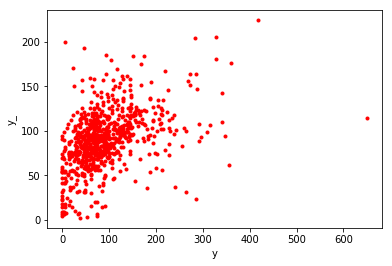

Epoch 135: R2 = 0.188793457559
Epoch 135: MSE = 3636.30828254


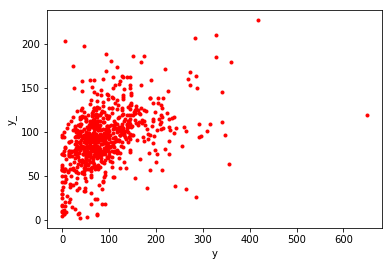

Epoch 140: R2 = 0.189776617941
Epoch 140: MSE = 3635.01881783


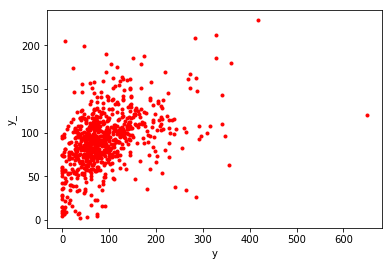

Epoch 145: R2 = 0.190833851296
Epoch 145: MSE = 3628.5362772


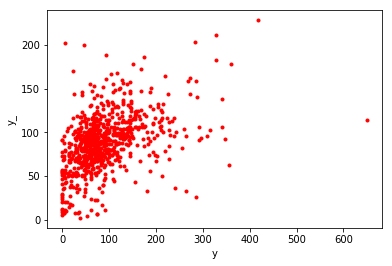

Epoch 150: R2 = 0.191938281329
Epoch 150: MSE = 3622.02129597


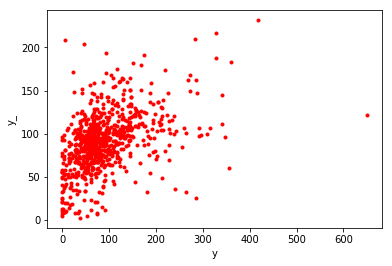

Epoch 155: R2 = 0.19580745395
Epoch 155: MSE = 3611.38723967


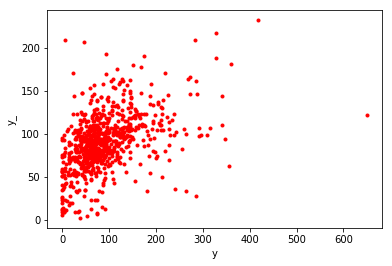

Epoch 160: R2 = 0.196266862592
Epoch 160: MSE = 3604.36471619


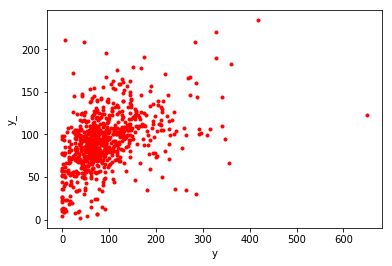

Epoch 165: R2 = 0.197120496917
Epoch 165: MSE = 3599.84984932


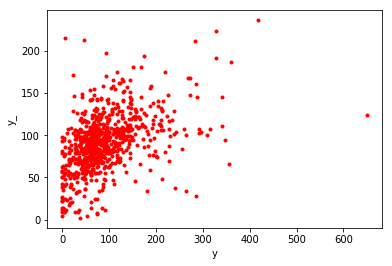

Epoch 170: R2 = 0.198678032814
Epoch 170: MSE = 3597.48929055


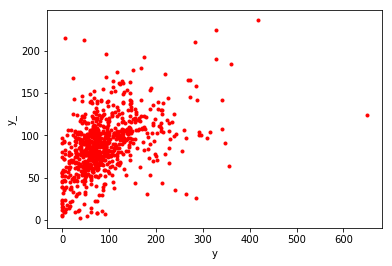

Epoch 175: R2 = 0.198578440155
Epoch 175: MSE = 3602.03138086


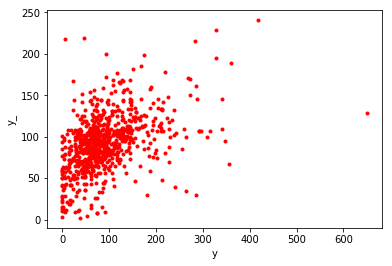

Epoch 180: R2 = 0.199922716795
Epoch 180: MSE = 3595.880266


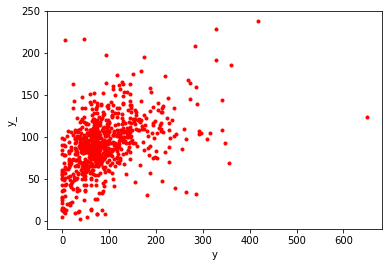

Epoch 185: R2 = 0.199712092705
Epoch 185: MSE = 3587.59858451


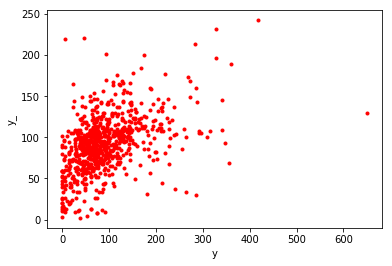

Epoch 190: R2 = 0.202131613876
Epoch 190: MSE = 3585.43969626


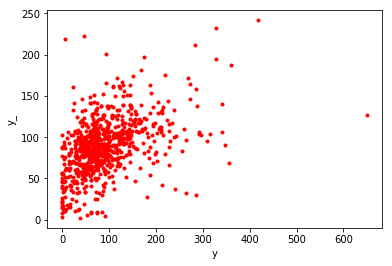

Epoch 195: R2 = 0.201615864303
Epoch 195: MSE = 3585.41561456


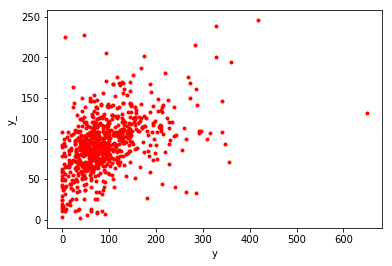

Epoch 200: R2 = 0.201518299769
Epoch 200: MSE = 3593.26130047


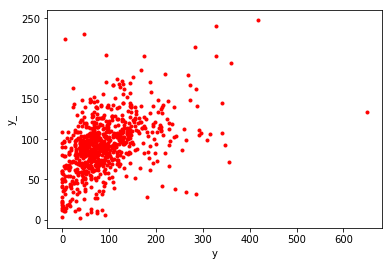

Epoch 205: R2 = 0.202882645734
Epoch 205: MSE = 3587.96814089


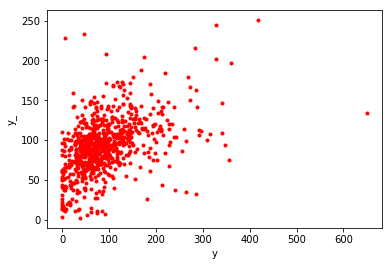

Epoch 210: R2 = 0.202671589739
Epoch 210: MSE = 3591.7690864


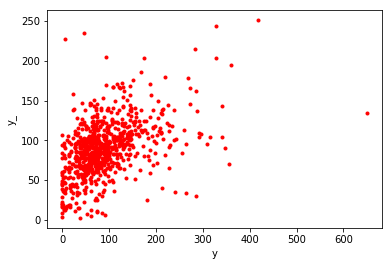

Epoch 215: R2 = 0.202646403745
Epoch 215: MSE = 3586.02764898


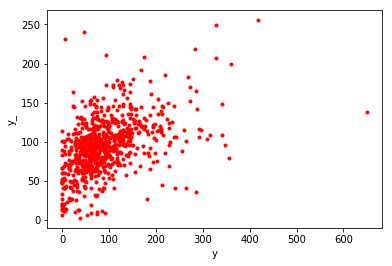

Epoch 220: R2 = 0.203238962374
Epoch 220: MSE = 3605.55444983


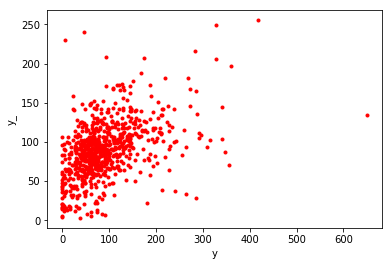

Epoch 225: R2 = 0.202077222896
Epoch 225: MSE = 3599.51376599


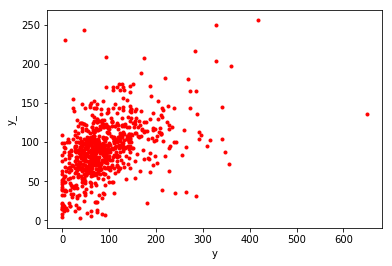

Epoch 230: R2 = 0.202262236351
Epoch 230: MSE = 3595.2388307


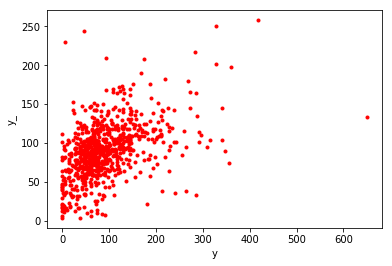

Epoch 235: R2 = 0.205888283597
Epoch 235: MSE = 3576.0787177


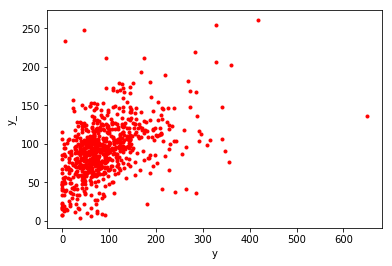

Epoch 240: R2 = 0.204119027859
Epoch 240: MSE = 3594.4437025


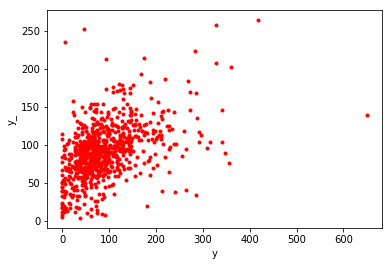

Epoch 245: R2 = 0.203559336563
Epoch 245: MSE = 3596.99768214


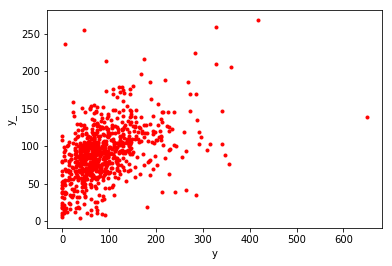

Epoch 250: R2 = 0.203959379071
Epoch 250: MSE = 3599.62041681


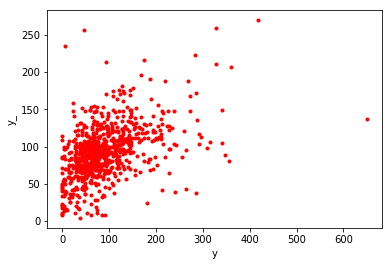

Epoch 255: R2 = 0.205199318854
Epoch 255: MSE = 3594.45782576


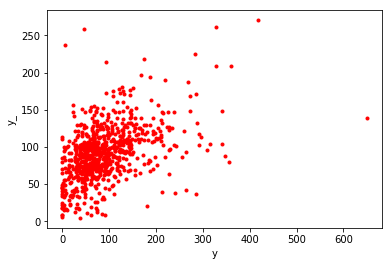

Epoch 260: R2 = 0.203813056173
Epoch 260: MSE = 3603.32912064


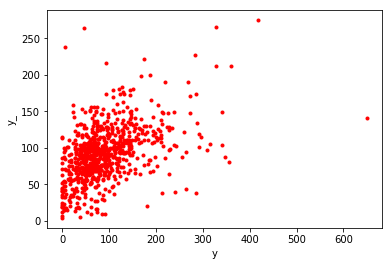

Epoch 265: R2 = 0.204832036811
Epoch 265: MSE = 3608.17510082


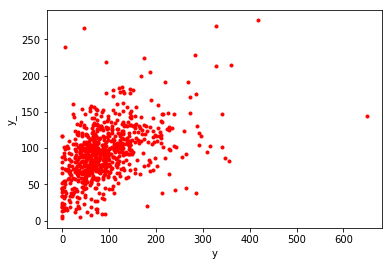

Epoch 270: R2 = 0.200575783173
Epoch 270: MSE = 3636.93256347


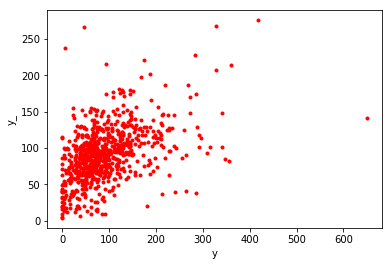

Epoch 275: R2 = 0.202099858131
Epoch 275: MSE = 3620.4487705


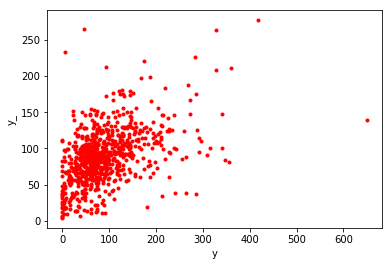

Epoch 280: R2 = 0.203220498775
Epoch 280: MSE = 3617.62178883


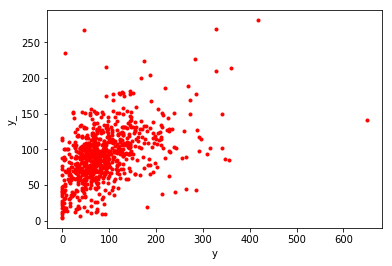

Epoch 285: R2 = 0.202654451328
Epoch 285: MSE = 3623.75490979


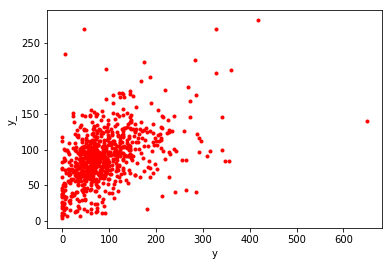

Epoch 290: R2 = 0.200041102794
Epoch 290: MSE = 3635.86582989


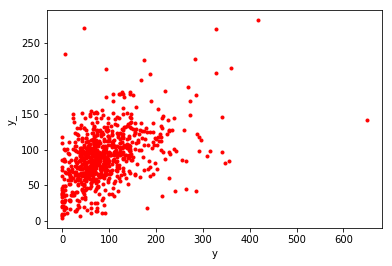

Epoch 295: R2 = 0.200368109939
Epoch 295: MSE = 3633.39030618


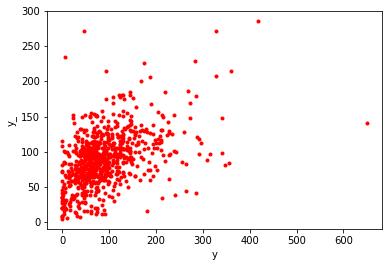

Epoch 300: R2 = 0.200502299932
Epoch 300: MSE = 3647.35412121


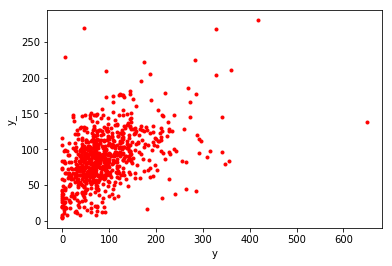

Epoch 305: R2 = 0.200391133835
Epoch 305: MSE = 3639.44256186


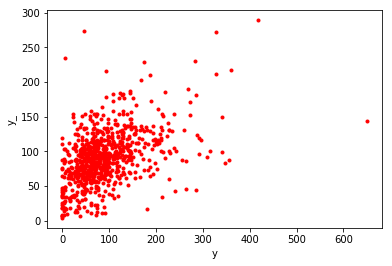

Epoch 310: R2 = 0.200508545088
Epoch 310: MSE = 3650.54465959


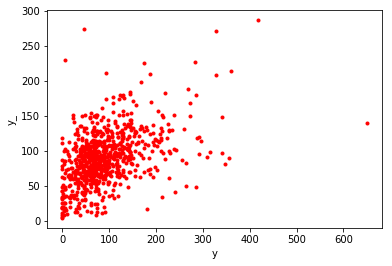

Epoch 315: R2 = 0.200147921591
Epoch 315: MSE = 3642.84853824


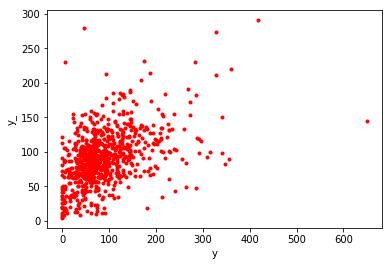

Epoch 320: R2 = 0.197314927406
Epoch 320: MSE = 3675.55471141


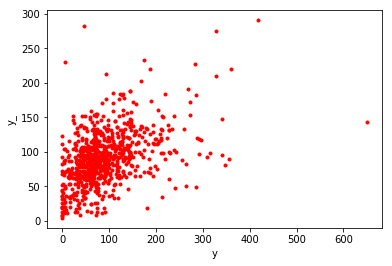

Epoch 325: R2 = 0.19612128678
Epoch 325: MSE = 3680.26638389


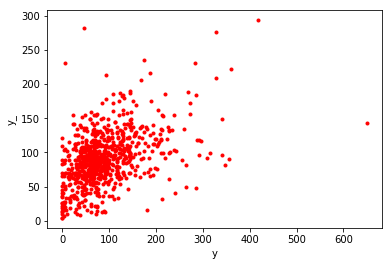

Epoch 330: R2 = 0.195585755762
Epoch 330: MSE = 3691.7283193


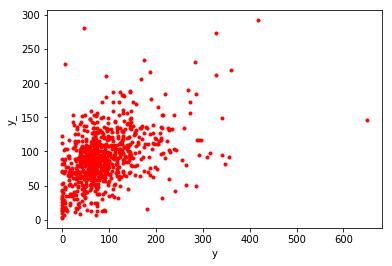

Epoch 335: R2 = 0.195064098182
Epoch 335: MSE = 3692.89344636


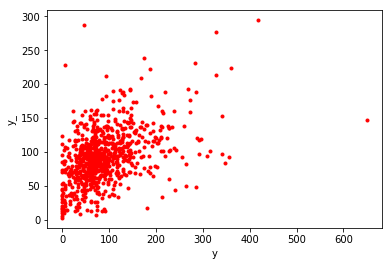

Epoch 340: R2 = 0.194857490381
Epoch 340: MSE = 3719.20825353


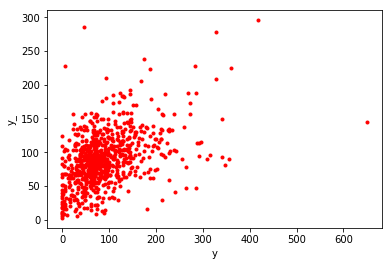

Epoch 345: R2 = 0.193083139968
Epoch 345: MSE = 3721.39896433


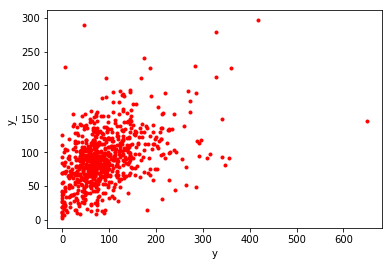

Epoch 350: R2 = 0.193022476464
Epoch 350: MSE = 3732.45235506


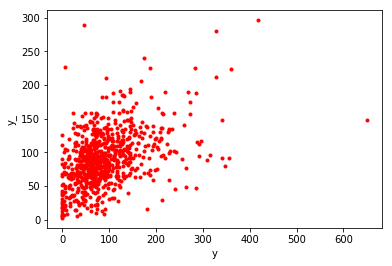

Epoch 355: R2 = 0.191885419866
Epoch 355: MSE = 3741.57839199


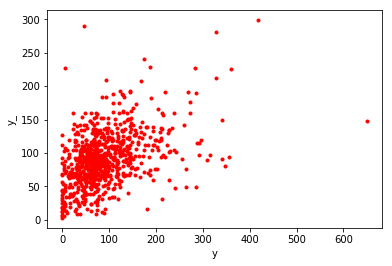

Epoch 360: R2 = 0.190357806774
Epoch 360: MSE = 3751.31962427


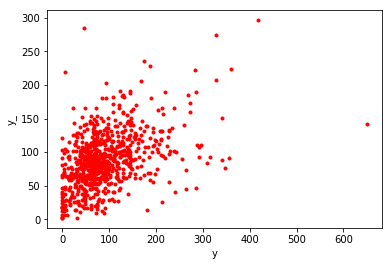

Epoch 365: R2 = 0.189911082911
Epoch 365: MSE = 3762.42688727


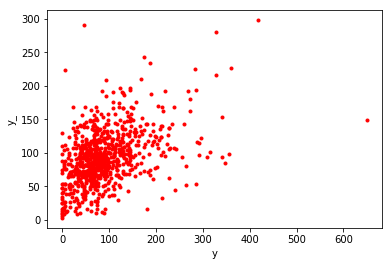

Epoch 370: R2 = 0.189643832526
Epoch 370: MSE = 3777.09932931


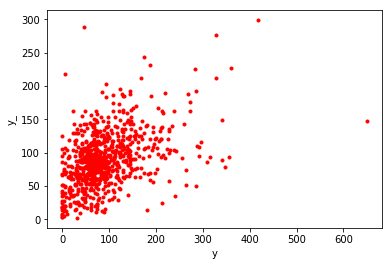

Epoch 375: R2 = 0.187230396465
Epoch 375: MSE = 3785.0405541


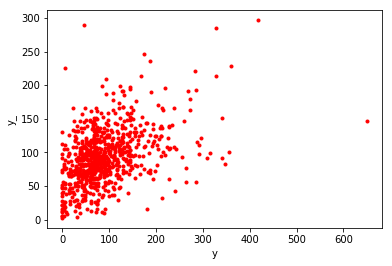

Epoch 380: R2 = 0.186713791153
Epoch 380: MSE = 3797.58756837


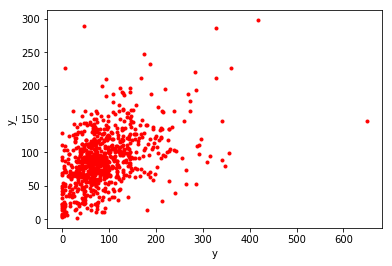

Epoch 385: R2 = 0.185355684531
Epoch 385: MSE = 3802.39185373


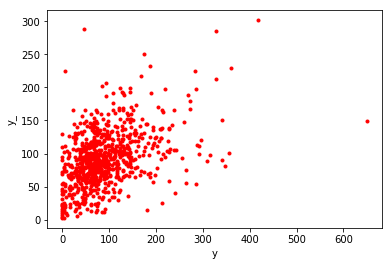

Epoch 390: R2 = 0.18631361972
Epoch 390: MSE = 3812.48427867


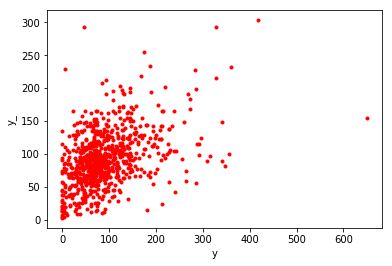

Epoch 395: R2 = 0.185808475762
Epoch 395: MSE = 3833.64066191


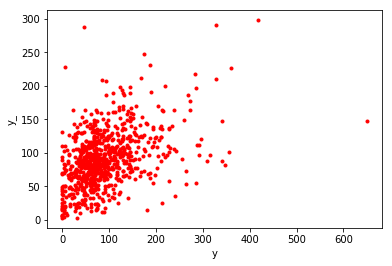

Epoch 400: R2 = 0.184885626287
Epoch 400: MSE = 3820.53109593


In [40]:
plot_test_epochs(dnnmodel, result, subset = 1)

## Having iteratively developed the network topology, load and compare several models:

In [23]:
# First load the model result pickles
model_results = []
i = 0
for filename in os.listdir("dnn_models"):
    path = str("dnn_models/" + filename)
    if ".pkl" in filename:
        model_results.append({"results": pkl.load(open(path, "rb")),
                              "file": filename,
                              "id": i})
        #print(path)
        #print(model_results[i]["results"]["history"][-1,])
        i += 1

# Then plot model metrics
def summarize_model(model_from_file):
    ''' 
    Produce plots summarizing r2 and MSE at each epoch for each model
    Also prints minimum MSE and max r2 for each model
    '''
    print(model_from_file["file"])
    print(model_from_file["id"])
    plt.plot(model_from_file["results"]["epoch"][1:],rsquared_one_to_many(model_from_file["results"]), 'r.')
    plt.ylabel('r2')
    plt.xlabel('epoch')
    plt.show()
    plt.plot(model_from_file["results"]["epoch"][1:],mse_one_to_many(model_from_file["results"]), 'b.')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.show()

dnn_10node_200epoch_tan-relu-linear_80pcttrain_nosoftmax_resultsdict.pkl
0
0.177343308397


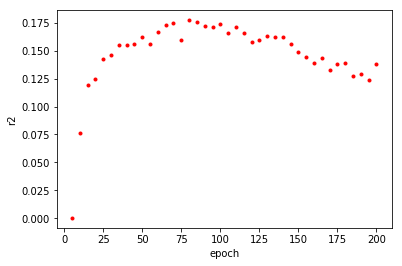

3709.34150188


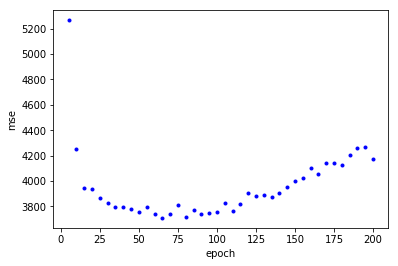

dnn_10node_200epoch_tan-relu-linear_80pcttrain_nosoftmax_with_dropout_L2linear_resultsdict.pkl
1
0.170911474106


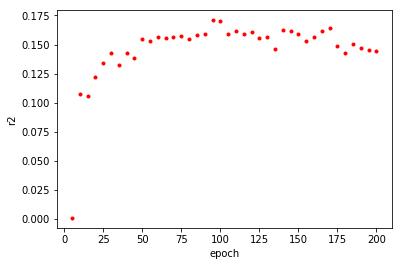

5649.79400907


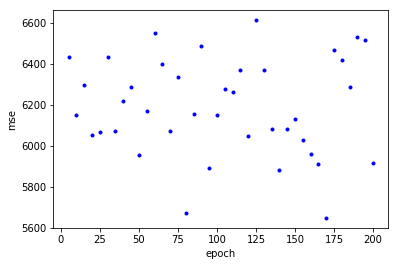

dnn_10node_200epoch_tan-relu-linear_80pcttrain_nosoftmax_with_dropout_resultsdict.pkl
2
0.175499922788


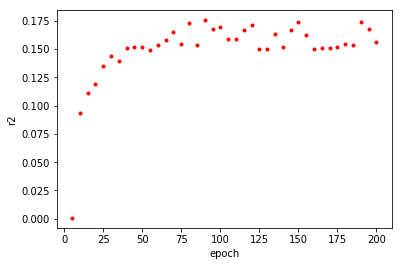

5739.98832438


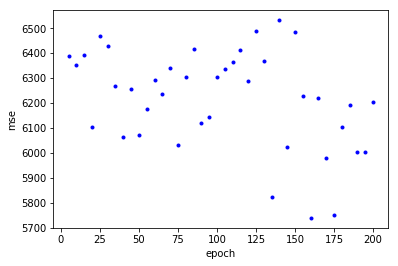

dnn_10node_200epoch_tan-relu-linear_80pcttrain_nosoftmax_with_dropout_L2linear_removed_weightdecay_resultsdict.pkl
3
0.179757167659


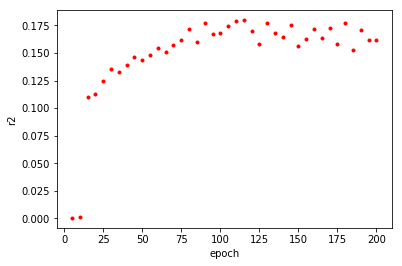

5863.4197824


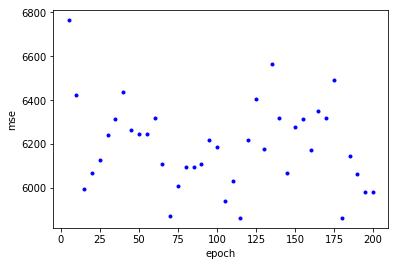

dnn_10node_200epoch_fewer_layers_80pcttrain_resultsdict.pkl
4
0.146380378945


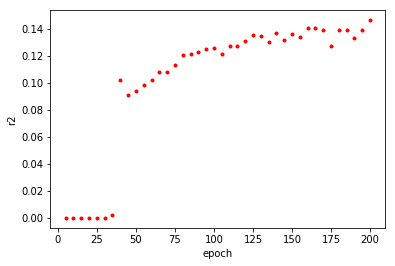

3914.18509503


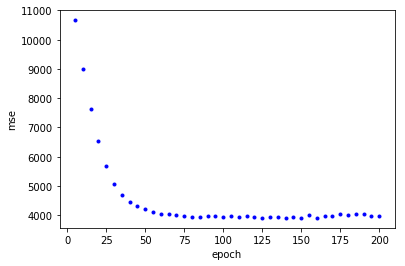

dnn_10node_200epoch_fewer_layers_plus_relu_80pcttrain_resultsdict.pkl
5
0.00251683056308


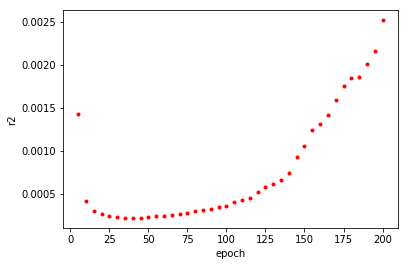

4469.27458442


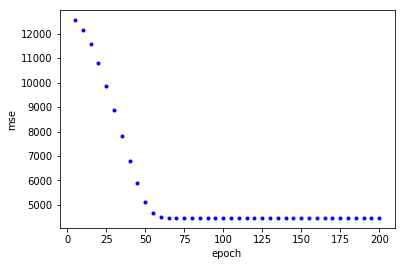

dnn_10node_200epoch_80pcttrain_resultsdict.pkl
6
0.155343263592


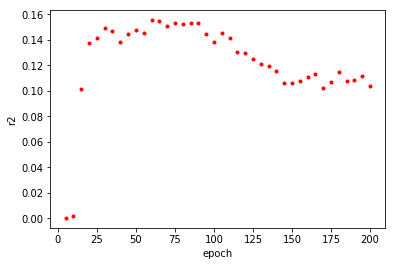

3836.52690912


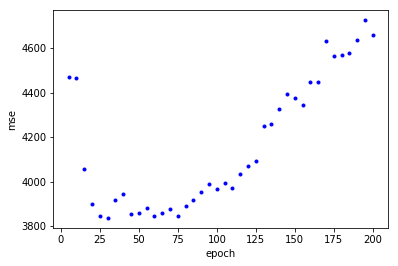

dnn_300node_2000epoch_80pcttrain_resultsdict.pkl
7
0.154742031311


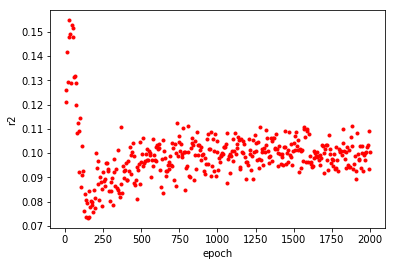

3891.79520948


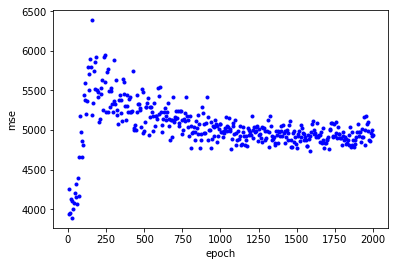

In [211]:
for m in model_results:
    summarize_model(m)

The best model so far is a three-hidden-layer architecture, with 10 nodes in each of tanh/relu/linear layers

Achieves MSE of ~3600 and R2 of ~0.18

## **Comparison to a linear regression**

In [79]:
import sklearn
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [80]:
linregX = pkl.load(open("tf_data/training_data_names.pkl", "rb"))
linregy = pkl.load(open("tf_data/training_labels_num.pkl", "rb"))

In [81]:
# One-hot encode vocab
vectorizer = CountVectorizer(linregX, ngram_range=(1,2))
lrX = vectorizer.fit_transform(linregX)
# Fit a model - LassoCV attempts to pick best L1 regularization
# Model is trained on 80% of data
linreg = linear_model.LassoCV()
linreg.fit(X=lrX[:int(len(linregy)*0.8)].toarray(), y=linregy[:int(len(linregy)*0.8)])

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [82]:
# How well does model predict training data
print("R2 on training data is " + str(rsquared(linreg.predict(lrX), linregy)))
print("R2 on test data is " + str(rsquared(linreg.predict(lrX[int(len(linregy)*0.8):]), linregy[int(len(linregy)*0.8):])))
print("MSE on training data is " + str(mean_squared_error(linreg.predict(lrX), linregy)))
print("MSE on test data is " + str(mean_squared_error(linreg.predict(lrX[int(len(linregy)*0.8):]), linregy[int(len(linregy)*0.8):])))


R2 on training data is 0.437429307758
R2 on test data is 0.246521381684
MSE on training data is 2697.88620597
MSE on test data is 3378.1952728


While the Lasso model with cross validation of regularization parameters (i.e. scikit-learn's LassoCV) does predict the test samples OK, its increased error on
the test data suggests that there's still some degree of overfitting.

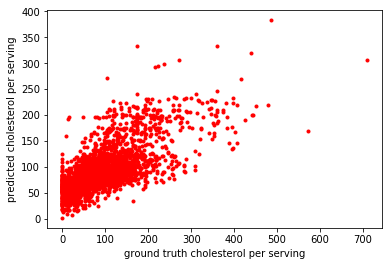

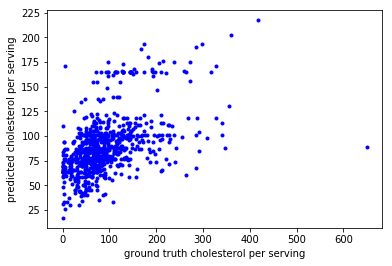

In [74]:
# How well does model predict the test data?
import matplotlib.pyplot as plt
plt.plot(linregy[:int(len(linregy)*0.8)], linreg.predict(lrX[:int(len(linregy)*0.8)]), 'r.')
plt.ylabel('predicted cholesterol per serving')
plt.xlabel('ground truth cholesterol per serving')
plt.show()

# How well does model predict the test data?
import matplotlib.pyplot as plt
plt.plot(linregy[int(len(linregy)*0.8):], linreg.predict(lrX[int(len(linregy)*0.8):]), 'b.')
plt.ylabel('predicted cholesterol per serving')
plt.xlabel('ground truth cholesterol per serving')
plt.show()

## Summary:
1. The MSE and R2 for the optimized linear models is so far superior to the best-performing neural net. However,
being trained on word vectors means that the neural net can predict out-of-sample cholesterol - e.g. for items on a 
menu not contained in the training database, though this is difficult to validate. We'd likely need far more data 
to fully exploit the deep neural nets.

2. There's a lot of work to be done in further exploring the tensorflow models:

    a. Can we optimize the tensorflow model's input data? So far, we took the simplest approach of averaging 
    the vectors of all the words in each food item's name. This is destructive. Can we either learn the relevant
    words or help the model by applying a heuristic?
    
    b. Other network architectures might improve the model somewhat
    
    c. The neural net's loss function - mean squared error - may not be optimal, as it optimizes for minimum error
    across the entire batch at each epoch. We care more about accurately predicting extreme values - avoiding
    high cholesterol items on a menu - than overall fit. Perhaps recasting as a classification problem is the right 
    way to go here, as in the original MenuSights?